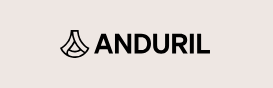

In [1]:
#from IPython import display yup
#display.Image(filename="./logos/Anduril-Logo-Horizontal-Black-SMALL.png", width=100)
#!{eval`ssh-agent -s`; ssh-add ~/.ssh/aicam_git; git pull}

In [2]:
%matplotlib widget
import ipywidgets as widgets
import numpy as np
import pandas
import pylab as pb
#print(pb.style.available)

In [3]:
#units.py
from math import pi

m = 1.0
km = 1e3*m
cm = 1e-2*m
mm = 1e-3*m
μm = 1e-6*m
nm = 1e-9*m

s = 1.0

Hz = 1.0/s

kg = 1.0

J = kg*m**2/s**2
W = J/s
fW = 1e-15*W


K = 1.0
k = 1.38064e-23*J/K

sr = 1.0


h = 6.62607015e-34*J*s
c = 299792458*m/s

C = 1.0
V = J/C
μV = 1e-6*V
mV = 1e-3*V
nV = 1e-9*V
q = 1.60217663e-19*C
A = C/s
nA = A*1e-9
pA = A*1e-12

Ω = V/A

eV = (q/C)*J

F = C/V
fF = 1e-15*F
pF = 1e-12*F

rad = 1.0
deg = (pi/180)*rad

In [4]:
#widgets/widgets.py
from IPython.display import display
from cycler import cycler

style = {'description_width': 'initial'}
layout = widgets.Layout(width='90%',
                align_items='stretch',
                #border='solid 2px'
                )

num_λ = widgets.BoundedIntText(100, min=1, max=1000, description='num_λ', style=style, layout=layout)
λ_range = widgets.FloatRangeSlider(value=[3.0,5.0], min=0.1,max=1000.0, description='λ_range [μm]', style=style,
                                  continuous_update=False)
T_scene = widgets.BoundedFloatText(300.0, min=1.0, max=10000, description=r'T_scene [K]', style=style, layout=layout,)

class DataFrameWidget(widgets.Output):
    def __init__(self):
        super().__init__()
        
        self._output = widgets.Output()
        self._widget = widgets.Box(children=[self._output,])
        self._widget.layout.height='400px'
        self._widget.layout.width='1024px'

        with self:
            self.clear_output(wait=True)
            display(self._widget)

    def display(self, df):
        with self._output:
            self._output.clear_output(wait=True)
            display(df)

class PlotWidget(widgets.Output):
    def __init__(self, fig, columns):
        self.fig = fig
        self.columns = columns
        self.x1_select = x1_select = widgets.Dropdown(
            options = columns,
            value = columns[0],
            description = 'x1',
            style=style,
            layout=layout,
        )
        self.x1_log = x1_log = widgets.Checkbox(description='x1_log', layout=layout)
        self.x1_log.observe(self.on_x1_log,'value')

        self.x2_select = x2_select = widgets.Dropdown(
            options = ['',]+columns,
            value = '',
            description = 'x2',
            style=style,
            layout=layout,
        )
        self.x2_select.observe(self.on_x2_select, 'value')
        self.x2_log = x2_log = widgets.Checkbox(description='x2_log', layout=layout)
        self.x2_log.observe(self.on_x2_log,'value')
        
        self.y1_select = y1_select = widgets.SelectMultiple(
            options = columns,
            value = [columns[1],],
            description = 'y1',
            rows=len(columns),
            style=style,
            layout=layout,
        )
        self.y1_log = y1_log = widgets.Checkbox(description='y1_log', layout=layout)
        self.y1_log.observe(self.on_y1_log,'value')
        self.y1_label = y1_label = widgets.Text(value='', description='y1_label', layout=layout, style=style)
        self.y1_label.observe(self.on_y1_label, 'value')
        
        self.y2_select = y2_select = widgets.Dropdown(
            options = ['',]+columns,
            value = '',
            description = 'y2',
            style=style,
            layout=layout,
            )
        self.y2_log = y2_log = widgets.Checkbox(description='y2log', layout=layout)
        self.y2_log.observe(self.on_y2_log,'value')

        self.overlay_file = overlay_file = widgets.FileUpload(accept='', 
                            multiple=False, icon='fa-chart-scatter', layout=layout)
        self.overlay_clear = overlay_clear = widgets.Button(description='Clear', layout=layout)
        self.overlay_clear.on_click(self.on_overlay_clear)

        display_settings = widgets.Accordion(children=[widgets.VBox([x1_log, x1_select,x2_log, x2_select]),
            widgets.VBox([y1_log, y1_select, y1_label],),
            widgets.VBox([y2_log, y2_select, overlay_file, overlay_clear],),
            ])
        display_settings.set_title(0,'x')
        display_settings.set_title(1,'y1')
        display_settings.set_title(2,'y2')
        display_settings.layout.width = '300px'

        #footer.layout.align_items = 'flex-start'
        #display_settings.layout.border = '1px solid #FFCC00'
        #fig.canvas.layout.border = '1px solid #FFCC00'
        #fig.canvas.layout.width = '600px'

        fig_box = widgets.Box(children=[fig.canvas,])
        fig_box.layout.width = '700px'
        #fig.canvas.layout.width = '700px'
        #fig_box.layout.border = 'solid 3px red'
        #fig.canvas.layout.border = 'solid 6px green'

        self._widget = widgets.AppLayout(
            left_sidebar = fig_box,
            center=None,
            right_sidebar = display_settings,
            align_items='top',
            justify_items='top left',
            #height='500px',
            )


        super().__init__()
        self.layout.height = '550px'
        with self:
            self.clear_output(wait=True)
            display(self._widget)

        self.df_overlay = None


    def on_x1_log(self, change=None):
        ax1 = self.fig.axes[0]
        if change['new'] == True:
            ax1.set_xscale('log')
        else:
            ax1.set_xscale('linear')
        ax1.relim()
        ax1.autoscale_view()
        self.fig.canvas.draw_idle()

    def on_x2_log(self, change=None):
        ax12 = self.fig.ax12
        if change['new'] == True:
            ax12.set_xscale('log')
        else:
            ax12.set_xscale('linear')
        ax12.relim()
        ax12.autoscale_view()
        self.fig.canvas.draw_idle()
    
    def on_y1_log(self, change=None):
        ax1 = self.fig.ax1
        if self.y1_log.value:
            ax1.set_yscale('symlog', linthresh=1e-12, subs=[0,], base=10, linscale=3.0)
            ax1.locator_params(axis='y', numticks=10)
        else:
            ax1.set_yscale('linear')
            #self.fig.axes[0].locator_params(axis='y', nbins=5)
        ax1.relim()
        ax1.autoscale(tight=True)
        self.fig.canvas.draw_idle()

    def on_y1_label(self, change=None):
        #print(self.y1_label.value)
        self.fig.ax1.set_ylabel(rf"{self.y1_label.value}")
        self.fig.canvas.draw_idle()

    def on_y2_log(self, change=None):
        #if not self.y2_select.value:
        #    return
        ax2 = self.fig.axes[1]
        if self.y2_log.value:
            ax2.set_yscale('symlog', linthresh=1e-12, subs=[0,], base=10, linscale=3.0)
            ax2.locator_params(axis='y', numticks=10)
        else:
            ax2.set_yscale('linear')
        ax2.relim()
        ax2.autoscale(axis='y', tight=True)
        self.fig.canvas.draw_idle()

    def on_x2_select(self, change=None):
        self.display(self.df)

    def on_overlay_clear(self, change=None):
        self.overlay_file.value = ()
        self.df_overlay = None
        self.display(self.df)


    def display(self, df):
        self.df = df
        pb.ioff()
        ax1 = self.fig.ax1
        ax2 = self.fig.ax2
        ax12 = self.fig.ax12
        for l in ax1.lines + ax1.collections + ax12.lines + ax2.lines + ax2.collections:
            l.remove()
        for ax in [ax1, ax2]:
            ax.legend_ = None
        
        ax12.xaxis.set_visible(False)
        ax2.yaxis.set_visible(False)

        x = df[self.x1_select.value]
        n_colors = len(cmaplist)
        line_cycler = cycler(color=[cmaplist[i % n_colors] for i in range(0,len(self.y1_select.value))],)
        line_cycler += cycler(linestyle=['-', '--', '-.',':'],)
        ax1.set_prop_cycle(line_cycler)
        for label in self.y1_select.value: 
            y1 = df[label]
            ax1.plot(x, y1, label=label)


        xmin = x.min()
        xmax = x.max()
        if (xmax > xmin):
            ax1.set_xlim(xmin, xmax)
            ax2.set_xlim(xmin, xmax)
        
        legend1 = ax1.legend()
        legend1.set_draggable(True, use_blit=True,)
        
        ax1.set_xlabel(fancy_labels[self.x1_select.value])

        if self.y1_label.value:
            ax1.set_ylabel(rf"{self.y1_label.value}")
        elif len(self.y1_select.value) == 1:
            ax1.set_ylabel(fancy_labels[self.y1_select.value[0]])
        else:
            ax1.set_ylabel('')

        if self.x2_select.value:
            x2 = df[self.x2_select.value]
            y1 = df[self.y1_select.value[0]]
            ax12.plot(x2, y1, ls='', label=None, color="None")
            ax12.set_xlabel(fancy_labels[self.x2_select.value])
            if self.x2_select.value in reverse_axis_labels:
                ax12.invert_xaxis()
            ax12.xaxis.set_visible(True)

            #ax12.relim()
            #ax12.autoscale(axis='both', tight=True)

        #ax1.relim()
        #ax1.autoscale(axis='both', tight=True)
        ##ax1.autoscale_view()
        #self.fig.canvas.draw_idle()

        

        #ax1.locator_params(nbins=5)
        #ax2.locator_params(nbins=5)
        if self.y2_select.value:
            if self.df_overlay is not None:
                x = self.df_overlay[self.x1_select.value]
                if self.y2_select.value in self.df_overlay.columns:
                    y1 = self.df_overlay[self.y2_select.value]
                    ax1.scatter(x, y1, marker='o', facecolors='none', edgecolors='k', s=80)
            else:
                y2 = df[self.y2_select.value]
                ax2.plot(x, y2, ls='--', label=self.y2_select.value,)
                ax2.set_ylabel(fancy_labels[self.y2_select.value])
                ax2.yaxis.set_visible(True)

                legend2 = ax2.legend()
                legend2.set_draggable(False, use_blit=True,)

        
        for ax in self.fig.axes:
            ax.relim()
            ax.autoscale(axis='both', tight=True)
        
        #ax2.relim()
        #ax2.autoscale(axis='both', tight=True)
        #ax2.autoscale_view()

        #self.fig.canvas.draw()
        #self.fig.canvas.flush_events()
        self.fig.canvas.draw_idle()
        
        #pb.sca(ax1)

In [9]:
#ui/plots.py
#pb.style.use('seaborn-poster')
# Just load seaborn & set theme and the chart looks better:
import seaborn as sns
#sns.set_style('white')
#sns.set_context("poster")
#sns.set_theme()
pb.rcParams['lines.linewidth'] = 2.5
pb.rcParams['xtick.labelsize'] = 'large'
pb.rcParams['ytick.labelsize'] = 'large'
pb.rcParams['axes.labelsize'] = 'x-large'
pb.rcParams['legend.fontsize'] = 'medium'
pb.rcParams["axes.formatter.limits"] = [-2,2]
pb.rcParams["axes.formatter.useoffset"] = False
pb.rcParams["axes.formatter.use_mathtext"] = True
pb.rcParams["figure.facecolor"] = (1.0,1.0,1.0,0.0)
pb.rcParams["axes.facecolor"] = (1.0,1.0,1.0,0.0)
pb.rcParams["savefig.facecolor"] = (1.0,1.0,1.0,1.0)
pb.rcParams["savefig.dpi"] = 300

#line_cycler = cycler(color=[pb.cm.jet(i) for i in np.linspace(1.0, 0.5, 10)])

cmap = pb.cm.Dark2
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (0,0,1.0,1.0)
cmaplist[1] = (1.0,0,0,1.0)
cmaplist[2] = (0.0,0.5,0,1.0)
#cmap = mpl.colors.ListedColormap(cmaplist, 'aicam_cmap', cmap.N)


figzoom = 1.2
figsize = (5.5*figzoom,4*figzoom)
def new_figure(num=None, dpi=None, xlabel=''):
    fig = pb.figure(num, dpi=dpi, figsize=figsize, clear=True)
    fig.subplots_adjust(left=0.2, right=0.8, bottom=0.2, top=0.8)
    ax1 = fig.add_subplot(1,1,1)
    fig.ax1 = ax1

    ax2 = ax1.twinx()
    fig.ax2 = ax2
    #ax2.yaxis.set_visible(False)
    #ax2.xaxis.set_visible(False)
    ax2.set_zorder(-10)

    ax12 = ax1.twiny()
    fig.ax12 = ax12
    ax12.xaxis.set_visible(False)
    ax12.yaxis.set_visible(False)
    ax12.set_zorder(-20)

    ax1.set_xlabel(xlabel)
    fig.canvas.resizable = False
    fig.canvas.toolbar_position = 'left'
    fig.canvas.header_visible = False

    ax1.locator_params(nbins=5)
    ax2.locator_params(nbins=5)
    return fig, ax1, ax2

### Interactive Diode Model (IDIOM)

In [35]:
#detector.py
from scipy.optimize import newton

def area_detector(P_d):
    return P_d**2

def R_i(λ, η, τ=0.0*s,  f=0.0*Hz, G=1.0, integrate=False):
    R = η*λ*q/(h*c)/np.sqrt(1.0 + (2.0*pi*f*τ)**2)*G
    return R


def detectivity(λ, η, T, NA, f=0.0*Hz, detector_type='PV'):
    H = photon_irradiance_at_detector(λ, T, NA)
    if detector_type == 'PV':
        D = (λ/h/c)*np.sqrt(η/2.0/H)
    elif detector_type == 'PC':
        D = (λ/h/c/2.0)*np.sqrt(η/H)
        
    return D

def J_dark_sat(T, λ_c):
    λ_c /= μm
    T /= K
    # Values Determined by Fit
    J_init = 8367.00001853855*A/cm**2  # dark current (A/cm^2)
    Pwr = 0.544071281108481
    C = -1.16239134096245
    λ_s = 0.200847423564122  # wavelength scale (um)
    λ_t = 4.63513642316149  # wavelength threshold (um)

    if λ_c >= λ_t:
        λ_e = λ_c
    if λ_c < λ_t:
        λ_e = λ_c / (1 - ((λ_s / λ_c) - (λ_s / λ_t))**Pwr)

    J_sat = J_init * np.exp(C * 1.24 * q / (k * λ_e * T))
    
#    print('Cutoff =  ' , np.round(lam_c,2), 'Jdark = ' , str(format(dcd, ".2e")))
#    print('')
    
    return J_sat

def J_diode(V_d, T, J_sat_1, n_1=1.0, J_sat_2=0.0, n_2=2.0):
    J_1 =  J_sat_1*(np.exp(q*V_d/(k*T)/n_1) - 1.0)
    J_2 =  J_sat_2*(np.exp(q*V_d/(k*T)/n_2) - 1.0)
    return J_1 + J_2

def dJ_diode_dV(V_d, T, J_sat_1, n_1=1.0, J_sat_2=0.0, n_2=2.0):
    dJ_1 = J_sat_1*(q/(k*T)/n_1)*np.exp(q*V_d/(k*T)/n_1)
    dJ_2 = J_sat_2*(q/(k*T)/n_2)*np.exp(q*V_d/(k*T)/n_2)
    return dJ_1 + dJ_2

def V_diode(V_bias, J_d, RA_s):
    return V_bias - J_d*RA_s

def V_diode_equation(x, V_bias, T, J_sat_1, n_1, J_sat_2, n_2, RA_s):
    J_d = J_diode(x, T, J_sat_1, n_1, J_sat_2, n_2)
    return x - V_diode(V_bias, J_d, RA_s)

def dV_diode_equation(x, V_bias, T, J_sat_1, n_1, J_sat_2, n_2, RA_s):
    dJ_d = dJ_diode_dV(x, T, J_sat_1, n_1, J_sat_2, n_2)
    return 1.0 + dJ_d*RA_s


def dark_current_density(V_bias, T, J_sat_1, n_1, J_sat_2, n_2, RA_sh, RA_s):
    V_th = k*T/q
    V_d = newton(V_diode_equation, x0=V_bias, args=(V_bias, T, J_sat_1, n_1, J_sat_2, n_2, RA_s),
                       fprime=dV_diode_equation,
                        tol=1.0*μV,
                        rtol=0.001,
                        full_output=False
                        )
    J_d = J_diode(V_d, T, J_sat_1, n_1, J_sat_2, n_2) + V_d/RA_sh
    return J_d, V_d

def dark_current(J_d, A_d):
    return J_d*A_d

def detector_resistance_area_product(V_d, T, J_sat_1, n_1, J_sat_2, n_2, RA_sh):
    RA = 1.0/(dJ_diode_dV(V_d, T, J_sat_1, n_1=n_1, J_sat_2=J_sat_2, n_2=n_2) + 1.0/RA_sh)
    return RA

def detector_resistance(RA, A_d):
    R = RA/A_d
    return R

In [26]:
#widgets/detector.py
########################################################
### Detector
########################################################

η = widgets.BoundedFloatText(0.5, min=0.0, max=1.0, description='η', style=style)
T_d = widgets.BoundedFloatText(120, min=1.0, max=400.0, description=r'T_d [K]', style=style)
λ_cutoff = widgets.FloatText(5.5, min=0.1, max=100.0, description=r'λ_cutoff [μm]', style=style)

T_d_range = widgets.FloatRangeSlider(value=[100.0,300.0], min=1.0,max=400.0, description='T_d_range [K]', style=style,
                                  continuous_update=False, readout_format='.1f')

J_sat = widgets.FloatText(J_dark_sat(T_d.value*K, λ_cutoff.value*μm), description='J_sat [A/cm^2]', style=style, disabled=True,)
P_detector = widgets.BoundedFloatText(10.0, min=1.0, max=1000.0, description=r'Pitch [μm]', style=style)
A_detector = widgets.FloatText(area_detector(P_detector.value*μm)/μm**2,
                               description='A_d [μm^2]', style=style, disabled=True,)
V_d = widgets.FloatText(-0.1, description='V_d [V]')
V_d_range = widgets.FloatRangeSlider(value=[-0.5,0.5], min=-5.0,max=5.0, description='V_range [V]', style=style,
                                  continuous_update=False, readout_format='.1f')

J_sat_1 = widgets.FloatSlider(J_sat.value, min=0.0, max=J_sat.value, step=J_sat.value/100.0, description='J_sat_1 [A/cm^2]',
                                    style=style, continuous_update=False, readout_format='.5s')
n_1 = widgets.FloatSlider(1.0, min=0.1, max=3.0, description='n_1', style=style)
J_sat_2 = widgets.FloatText(0.0, min=0.0, max=J_sat.value, step=J_sat.value/100.0, description='J_sat_2 [A/cm^2]',
                                    style=style, continuous_update=False, readout_format='.5s', disabled=True)
n_2 = widgets.FloatSlider(2.0, min=0.1, max=3.0, description='n_2', style=style)
R_s = widgets.FloatSlider(1.0, min=0.0, max=1e6, description='R_s [Ω]',
                            style=style, continuous_update=False,readout_format='.5s')
R_sh = widgets.FloatLogSlider(1e11, min=0, max=20, description='R_sh [Ω]',)

num_rows = widgets.BoundedIntText(1024, min=1, max=2**16, description=r'num_rows', style=style)
num_cols = widgets.BoundedIntText(1024, min=1, max=2**16, description=r'num_cols', style=style)


detector_model_controls = widgets.Accordion(children=[widgets.VBox([J_sat_1, n_1,
                                                                J_sat_2, n_2,
                                                                R_sh, R_s,
                                                        ]),
                                                        ])
detector_model_controls.set_title(0, 'Diode Model')
detector_controls = widgets.VBox([P_detector, T_d, T_d_range,
                                  #η,
                                  λ_cutoff, V_d, V_d_range, detector_model_controls,])

J_dark = widgets.FloatText(0.0, description='J_dark [A/cm^2]', style=style, disable=True)
I_dark = widgets.FloatText(0.0, description='I_dark [nA]', style=style, disable=True)
V_dd = widgets.FloatText(0.0, description='V_diode [V]', style=style, disable=True)
RA_d = widgets.FloatText(0.0, description='RA_d [Ω*cm^2]', style=style, disable=True)

RA_sh = widgets.FloatText(0.0, description='RA_sh [Ω*cm^2]', style=style, disable=True)
RA_s = widgets.FloatText(0.0, description='RA_s [Ω*cm^2]', style=style, disable=True)

R_d = widgets.FloatText(0.0, description='R_d [Ω]', style=style, disable=True)
N_dark = widgets.FloatText(0.0, description='N_dark [Me-]', style=style, disable=True)
I_photo = widgets.FloatText(0.0, description='I_photo [nA]', disable=True, style=style)

width = widgets.FloatText(0.0, description='Width [mm]', disable=True, style=style)
height = widgets.FloatText(0.0, description='Height [mm]', disable=True, style=style)


V_d_columns=['V_d [V]', 'V_diode [V]', 'J_dark [A/cm^2]', 'I_dark [nA]', 'RA_d [Ω*cm^2]', 'R_d [Ω]']
T_d_columns=['T_d [K]','J_sat [A/cm^2]', 'I_sat [A]',]

det_λ_columns = ['λ [μm]', 'E [eV]', 'L_qd [photon/s/cm^2/sr/μm]', 'L_ed [W/cm^2/sr/μm]',
                'R_id [A/W]',]

pb.ioff()
V_d_fig, V_d_ax1, V_d_ax2 = new_figure(num=3, xlabel='Detector Bias [V]')
T_d_fig, T_d_ax1, T_d_ax2 = new_figure(num=4, xlabel='Detector Temperature [K]')
det_λ_fig, det_λ_ax1, det_λ_ax2 = new_figure(num=5, xlabel='Wavelength [μm]')
pb.ion()

V_d_plot = PlotWidget(V_d_fig, V_d_columns)
T_d_plot = PlotWidget(T_d_fig, T_d_columns)

V_d_sheet = DataFrameWidget()
T_d_sheet = DataFrameWidget()

hovel_sheet = DataFrameWidget()

detector_summary = DataFrameWidget()

temperature_output = widgets.Tab(children=[T_d_plot,T_d_sheet])
temperature_output.set_title(0,'plot')
temperature_output.set_title(1,'table')


bias_output = widgets.Tab(children=[V_d_plot,V_d_sheet])
bias_output.set_title(0,'plot')
bias_output.set_title(1,'table')



det_λ_sheet = DataFrameWidget()

det_λ_output = widgets.Tab(children=[det_λ_sheet, widgets.Output()])
det_λ_output.set_title(0,'table')
det_λ_output.set_title(1,'plot')

detector_output = widgets.Tab(children=[#detector_summary,
                                temperature_output,
                                bias_output,
                        ])
#detector_output.set_title(0,'summary')
detector_output.set_title(0,'temperature')
detector_output.set_title(1,'bias')

In [24]:
#fancy_labels.py
fancy_labels = {
    'λ [μm]': r'Wavelength [$μm$]',
    'Fλ/d': r"Fλ/d",
    'E [eV]': r'Energy [$eV$]',
    'T_target [K]': r'Target Temperature [$K$]',
    'R_target [km]': r'Detection Range [$km$]',
    'R_target [km^2/μm]': r'Detection Range [$km^2/μm$]',
    'D* [cm√Hz/W]': r'Detectivity [$cm√Hz/W$]',
    'T_target [K]': 'Target Temperature [K]',
    'I_target [W/sr]': 'Target Intensity [W/sr]',
    'I_target [W/sr/μm]': 'Target Intensity [W/sr/μm]',
    'L_q [photon/s/cm^2/sr/μm]': r'$Radiance~\left[ \frac{photons}{s\cdot cm^2 \cdot sr \cdot μm} \right]$',
    'L_e [W/cm^2/sr/μm]': r'$Radiance~\left[\frac{W}{cm^2 \cdot sr \cdot μm} \right]$',
    'TX_atm': 'Atmospheric Transmission',
    'R_i [A/W]': r'Responsivity [$A/W$]',
    'T_d [K]': r'Detector temperature [K]',
    'J_sat [A/cm^2]': r'Dark Current [$A/cm^2$]',
    'I_sat [A]': r'Dark Current [$A$]',
    'V_d [V]': r'Detector Bias [$V$]',
    'V_diode [V]': r'Diode Bias [$V$]',
    'J_dark [A/cm^2]': r'Dark Current [$A/cm^2$]',
    'I_dark [nA]': r'Dark Current [$nA$]',
    'RA_d [Ω*cm^2]': r'RA_dark [$Ω cm^2$]',
    'R_d [Ω]': r'Detector Resistance [$Ω$]',
    'τ_int [s]': r'Integration Time [$s$]',
    'τ_read [s]': r'Readout Time [$s$]',
    'N_photo [e-]': r'Photo Charge [$e-$]',
    'N_dark [e-]': r'Dark Charge [$e-$]',
    'N_total [e-]': r'Total Charge [$e-$]',
    'DN': r'Digital Number',
    'NEC_photo [e-]': r'Photon Noise [$e-$]',
    'NEC_dark [e-]': r'Detector Noise [$e-$]',
    'NEC_johnson [e-]': r'Johnson_Noise [$e-$]',
    'NEC_preamp [e-]': r'Preamp Noise [$e-$]',
    'NEC_1/f_det [e-]': r'Detector 1/f Noise [$e-$]',
    'NEC_1/f_roic [e-]': r'Readout 1/f Noise [$e-$]',
    'NEC_1/f_corr [e-]': r'Correlated 1/f Noise [$e-$]',
    'NEC_1/f [e-]': r'1/f Noise [$e-$]',
    'NEC_kTC [e-]': r'kTC Noise [$e-$]',
    'NEC_adc [e-]': r'ADC Noise [$e-$]',
    'NEC_total [e-]': r'Readout Noise [$e-$]',
    'v_s [V]': r"Signal Voltage [$V$]",
    'v_n [V]': r"Signal Noise [$V$]",
    'SNR_total': r"SNR Total",
    'SNR_photo': r"SNR Photo",
    'NETD [K]': r'$NETD~[K]$',
    'NEI [photons/s/cm^2]': r'$NEI~ \left[ \frac{photons}{s \cdot cm^2} \right]$',
    'NEP [fW]': r'$NEP~[fW]$'
}

save_columns_mapper = {
    'λ [μm]': r'Wavelength',
    'Fλ/d' : r"F_lambda_over_d",
    'E [eV]': r'Energy',
    'T_target [K]': r'Target_Temperature',
    'R_target [km]': r'Detection_Range',
    'R_target [km^2/μm]': r'Spectral_Detection_Range',
    'D* [cm√Hz/W]': r'Detectivity',
    'T_target [K]': 'Target_Temperature',
    'I_target [W/sr]': 'Target_Intensity',
    'I_target [W/sr/μm]': 'Spectral_Target_Intensity',
    'L_q [photon/s/cm^2/sr/μm]': r'Photon_Radiance',
    'L_e [W/cm^2/sr/μm]': r'Power_Radiance',
    'TX_atm': 'Atmospheric_Transmission',
    'R_i [A/W]': r'Current_Responsivity',
    'T_d [K]': r'Detector_Temperature',
    'J_sat [A/cm^2]': r'Dark_Current_Density_Saturation',
    'I_sat [A]': r'Dark_Current_Saturation',
    'V_d [V]': r'Detector_Bias',
    'V_diode [V]': r'Diode_Bias',
    'J_dark [A/cm^2]': r'Dark_Current_Density',
    'I_dark [nA]': r'Dark_Current',
    'RA_d [Ω*cm^2]': r'RA_dark',
    'R_d [Ω]': r'Detector_Resistance',
    'τ_int [s]': r'Integration_Time',
    'τ_read [s]': r'Readout_Time',
    'N_photo [e-]': r'Photo_Charge',
    'N_dark [e-]': r'Dark_Charge',
    'N_total [e-]': r'Total_Charge',
    'DN': r'Digital_Number',
    'NEC_photo [e-]': r'Photon_Noise',
    'NEC_dark [e-]': r'Detector_Noise',
    'NEC_johnson [e-]': r'Johnson_Noise',
    'NEC_preamp [e-]': r'Preamp_Noise',
    'NEC_1/f_det [e-]': r'Detector_1overf_Noise',
    'NEC_1/f_roic [e-]': r'Readout_1overf_Noise',
    'NEC_1/f_corr [e-]': r'Correlated_1overf_Noise',
    'NEC_1/f [e-]': r'1overf Noise',
    'NEC_kTC [e-]': r'kTC_Noise',
    'NEC_adc [e-]': r'ADC_Noise',
    'NEC_total [e-]': r'Readout_Noise',
    'v_s [V]': r"Signal_Voltage",
    'v_n [V]': r"Signal_Noise",
    'SNR_total': r"SNR_Total",
    'SNR_photo': r"SNR Photo",
    'NETD [K]': r'NETD',
    'NEI [photons/s/cm^2]': r'NEI_Photon',
    'NEP [fW]': r'NEP'
}

reverse_axis_labels = ['E [eV]',]

In [33]:
#Td_df.py
T_d_df = pandas.DataFrame(columns=T_d_columns,)
column_format = {'J_sat [A/cm^2]': '{:.6e}', 'I_sat [A]': '{:.6e}'}
def calculate_T_d(change=None):
    T_1, T_2 = T_d_range.value 
    T = np.linspace( T_1,  T_2, 100)*K
    T_d_df.drop(T_d_df.index,inplace=True)

    T_d_df['T_d [K]'] = T
    T_d_df['J_sat [A/cm^2]'] = J_dark_sat(T, λ_cutoff.value*μm)/(A/cm**2)

    T_d_sheet.display(T_d_df.style.format(column_format))#.hide(axis='index'))

    T_d_plot.display(T_d_df)

T_d_plot.x1_select.observe(calculate_T_d, 'value')
T_d_plot.y1_select.observe(calculate_T_d, 'value')
T_d_plot.y2_select.observe(calculate_T_d, 'value')
calculate_T_d()

In [36]:
#Vd_df.py
V_d_df = pandas.DataFrame(columns=V_d_columns,)
column_format = '{:.6e}' #{'J_dark [A/cm^2]': '{:.6e}', 'RA_dark [Ω*cm^2]': '{:.6e}'}

def calculate_V_d(change=None):
    #print(change)

    V_1, V_2 = V_d_range.value 
    V_bias = np.linspace(V_1,  V_2, 1000)
    V_d_df.drop(V_d_df.index,inplace=True)

    V_d_df['V_d [V]'] = V_bias

    RA_sh.value = (R_sh.value*Ω*A_detector.value*μm**2)/(Ω*cm**2)
    RA_s.value = (R_s.value*Ω*A_detector.value*μm**2)/(Ω*cm**2)

    J_sat.value = J_dark_sat(T_d.value*K, λ_cutoff.value*μm)/(A/cm**2)
    J_sat_1.max = J_sat.value
    step = J_sat.value/10.0
    J_sat_1.step = step
    J_sat_2.max = J_sat.value
    J_sat_2.step = step
    
    J_sat_2.value = J_sat.value - J_sat_1.value

    J_d, v_dd = dark_current_density(V_bias*V, T_d.value*K, J_sat_1.value*(A/cm**2), n_1.value,
                                J_sat_2.value*(A/cm**2), n_2.value,
                                RA_sh.value*(Ω*cm**2), RA_s.value*(Ω*cm**2))
    V_d_df['V_diode [V]'] = v_dd/(V)
    V_d_df['J_dark [A/cm^2]'] = J_d/(A/cm**2)
    V_d_df['I_dark [nA]'] = dark_current(V_d_df['J_dark [A/cm^2]']*(A/cm**2), A_detector.value*μm**2)/nA

   

    V_d_df['RA_d [Ω*cm^2]'] = detector_resistance_area_product(V_d_df['V_diode [V]']*V, 
                                    T_d.value*K, J_sat_1.value*(A/cm**2), n_1.value,
                                    J_sat_2.value*(A/cm**2), n_2.value,
                                    RA_sh.value*(Ω*cm**2))/(Ω*cm**2)
    V_d_df['R_d [Ω]'] = detector_resistance(V_d_df['RA_d [Ω*cm^2]']*(Ω*cm**2), A_detector.value*μm**2)/Ω

    V_d_sheet.display(V_d_df.style.format(column_format))#.hide(axis='index'))

    V_d_plot.display(V_d_df)

T_d.observe(calculate_V_d, 'value')
λ_cutoff.observe(calculate_V_d,'value')

V_d_range.observe(calculate_V_d,'value')
J_sat_1.observe(calculate_V_d, 'value')
n_1.observe(calculate_V_d, 'value')
#J_sat_2.observe(calculate_V_d, 'value')
n_2.observe(calculate_V_d, 'value')
R_sh.observe(calculate_V_d,'value')
R_s.observe(calculate_V_d,'value')
A_detector.observe(calculate_V_d,'value')

V_d_plot.x1_select.observe(calculate_V_d, 'value')
V_d_plot.y1_select.observe(calculate_V_d, 'value')
V_d_plot.y2_select.observe(calculate_V_d, 'value')
calculate_V_d()

In [38]:
#ui.py
def calculate(change=None):
    calculate_T_d(change=change)
    calculate_V_d(change=change)
calculate()
    

def on_P_detector(change=None):
    A_detector.value = area_detector(P_detector.value*μm)/μm**2
    calculate()
P_detector.observe(on_P_detector, 'value')


T_d.observe(calculate, 'value')
T_d_range.observe(calculate, 'value')
λ_cutoff.observe(calculate, 'value')


V_d.observe(calculate,'value')
V_d_range.observe(calculate, 'value')
R_sh.observe(calculate,'value')
R_s.observe(calculate,'value')
J_sat_1.observe(calculate, 'value')
J_sat_2.observe(calculate, 'value')
n_1.observe(calculate, 'value')
n_2.observe(calculate, 'value')


controls = widgets.Accordion(children=[detector_controls,])
controls.set_title(0,'Detector')
controls.layout.width = '450px'

output_tab = widgets.Tab(children=[detector_output,],)
output_tab.layout.width = '90%'
#output_tab.layout.height = '800px'
#output_tab.set_title(0,'Summary')
output_tab.set_title(0,'Detector')


main_ui = widgets.AppLayout(header=None, left_sidebar=controls,
center=None, right_sidebar=output_tab, footer=None,
                                pane_widths=[1,0,3],
                                pane_heights=['1fr','740px','1fr'],)
main_ui

AppLayout(children=(Accordion(children=(VBox(children=(BoundedFloatText(value=10.0, description='Pitch [μm]', …

#### [Diode Detector](./doc/Diode_Detector.ipynb)